In [1]:
import os
import sys

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [55]:
import shutil
import io
import random

import tqdm.auto as tqdm
import h5py
import numpy as np
import pandas as pd
import cv2
import PIL
import PIL.Image

import datasets

In [4]:
ds = datasets.load_dataset("DereWah/mk64-steering")

In [5]:
type(ds)

datasets.dataset_dict.DatasetDict

In [6]:
ds.keys()

dict_keys(['train'])

In [7]:
ds_train = ds['train']
type(ds_train), len(ds_train)

(datasets.arrow_dataset.Dataset, 70)

In [8]:
ds_train.column_names

['__key__', '__url__', 'hdf5']

In [9]:
sample = ds_train[0]

In [10]:
print(type(sample), sample.keys())
[len(sample[k]) for k in sample.keys()]

<class 'dict'> dict_keys(['__key__', '__url__', 'hdf5'])


[31, 139, 231348000]

In [11]:
print(sample['__key__'])

LR_expert/25-11-2024-11-59-11_1


In [12]:
print(sample['__url__'])

/home/mluser/.cache/huggingface/hub/datasets--DereWah--mk64-steering/snapshots/a8ecd5b3741a2f6a4f68bbdec2e0e47414e2e292/LR/LR_expert.tar.gz


In [14]:
hdf = io.BytesIO(sample['hdf5'])

In [15]:
type(hdf)

_io.BytesIO

In [41]:
with h5py.File(hdf, 'r') as f:
    print('keys:', len(f.keys()))
    print(list(f.keys())[:10])
    x_data, y_data = f['frame_0_x'][:], f['frame_0_y'][:]

keys: 2000
['frame_0_x', 'frame_0_y', 'frame_100_x', 'frame_100_y', 'frame_101_x', 'frame_101_y', 'frame_102_x', 'frame_102_y', 'frame_103_x', 'frame_103_y']


In [34]:
x_data.shape, x_data.dtype

((240, 320, 3), dtype('uint8'))

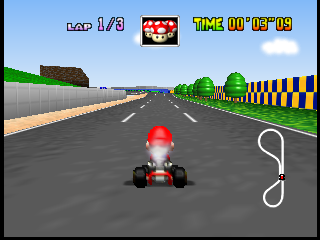

In [39]:
PIL.Image.fromarray(x_data[:,:,::-1])

In [38]:
y_data.shape, y_data.dtype

((22,), dtype('int64'))

In [40]:
y_data

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [42]:
len(ds_train)

70

In [46]:
for i, sample in enumerate(ds_train):
    hdf = io.BytesIO(sample['hdf5'])
    with h5py.File(hdf, 'r') as f:
        frames = len(f.keys()) // 2
    print(i, 'key', sample['__key__'], 'frames', frames)

0 key LR_expert/25-11-2024-11-59-11_1 frames 1000
1 key LR_expert/25-11-2024-11-59-11_10 frames 1000
2 key LR_expert/25-11-2024-11-59-11_11 frames 1000
3 key LR_expert/25-11-2024-11-59-11_12 frames 1000
4 key LR_expert/25-11-2024-11-59-11_13 frames 1000
5 key LR_expert/25-11-2024-11-59-11_14 frames 1000
6 key LR_expert/25-11-2024-11-59-11_15 frames 1000
7 key LR_expert/25-11-2024-11-59-11_16 frames 1000
8 key LR_expert/25-11-2024-11-59-11_17 frames 1000
9 key LR_expert/25-11-2024-11-59-11_18 frames 1000
10 key LR_expert/25-11-2024-11-59-11_19 frames 1000
11 key LR_expert/25-11-2024-11-59-11_2 frames 1000
12 key LR_expert/25-11-2024-11-59-11_20 frames 1000
13 key LR_expert/25-11-2024-11-59-11_21 frames 1000
14 key LR_expert/25-11-2024-11-59-11_22 frames 1000
15 key LR_expert/25-11-2024-11-59-11_23 frames 1000
16 key LR_expert/25-11-2024-11-59-11_24 frames 1000
17 key LR_expert/25-11-2024-11-59-11_25 frames 1000
18 key LR_expert/25-11-2024-11-59-11_26 frames 1000
19 key LR_expert/25-11-2

In [61]:
sample = random.choice(ds_train)
hdf = io.BytesIO(sample['hdf5'])
video_name = '/tmp/mk64-sample.mp4'

def action_to_label(action):
    s = ""
    turn = np.nonzero(action[:21])[0] - 10
    if turn < 0:
        s = f"L {abs(turn)}"
    elif turn > 0:
        s = f'R {turn}'
    if action[-1]:
        s += 'boost'
    return s

with h5py.File(hdf, 'r') as f:
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    outvideo = cv2.VideoWriter(video_name, fourcc, 24.0, (x_data.shape[1], x_data.shape[0]))
    for i in tqdm.trange(1000, desc='writing frames'):
        x_key = f'frame_{i}_x'
        y_key = f'frame_{i}_y'
        if x_key not in f or y_key not in f:
            break
        cv2_image = f[x_key][:]
        action = action_to_label(f[y_key][:].tolist())
        cv2.putText(cv2_image, action, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        outvideo.write(cv2_image)
    outvideo.release()

shutil.copy(video_name, './tmp-mk64-sample.mp4')

writing frames:   0%|          | 0/1000 [00:00<?, ?it/s]

'./tmp-mk64-sample.mp4'

In [62]:
from IPython.display import Video

Video('./tmp-mk64-sample.mp4')